<a href="https://colab.research.google.com/github/rajvanshi08/Gym_form/blob/main/yolov5_alpr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 for Automatic License Plate Recognition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone YOLOv5 code
!git clone https://github.com/rkuo2000/yolov5
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 3390, done.
remote: Total 3390 (delta 0), reused 0 (delta 0), pack-reused 3390
Receiving objects: 100% (3390/3390), 7.02 MiB | 4.41 MiB/s, done.
Resolving deltas: 100% (2274/2274), done.
/content/yolov5


In [3]:
!echo "train: Dataset/train/images" > data/alpr.yaml
!echo "val:   Dataset/train/images" >> data/alpr.yaml

!echo "nc : 1" >> data/alpr.yaml
!echo "names: ['license_plate']" >> data/alpr.yaml

!cat data/alpr.yaml

train: Dataset/train/images
val:   Dataset/train/images
nc : 1
names: ['license_plate']


## Prepare Dataset

In [4]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [15]:
FILE_ROOT = "/content/drive/MyDrive/png_img/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [6]:
!mkdir -p Dataset/train/labels

In [7]:
# copy images
!mkdir -p Dataset/train
!cp -rf /content/drive/MyDrive/png_img/images/ Dataset/train

In [10]:
!mkdir -p Dataset/val
!cp -rf /content/drive/MyDrive/png_img/images/cam1.png Dataset/val

### Convert COCO Annotations to YOLOv5 Labels

In [12]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license_plate']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [16]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  cam2.xml
/content/drive/MyDrive/png_img/annotations/cam2.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 190 620 334 656
Dataset/train/labels/cam2.txt
file name:  cam3.xml
/content/drive/MyDrive/png_img/annotations/cam3.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 108 353 279 388
Dataset/train/labels/cam3.txt
file name:  cam4.xml
/content/drive/MyDrive/png_img/annotations/cam4.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 168 329 400 394
Dataset/train/labels/cam4.txt
file name:  cam5.xml
/content/drive/MyDrive/png_img/annotations/cam5.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 197 539 353 565
Dataset/train/labels/cam5.txt
file name:  cam6.xml
/content/drive/MyDrive/png_img/annotations/cam6.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 91 224 178 250
Dataset/train/labels/cam6.txt
file name:  cam7.xml
/content/drive/MyDrive/png_img/annotations/cam7.xml
box:(c,xmin,ymin,xmax,ymax) license_plate 35 321 177 364
Dataset/train/labels/cam7.txt
file name:  cam8.xml
/content/drive/

In [17]:
!mkdir -p Dataset/val/labels
!cp -rf /content/yolov5/Dataset/train/labels/cam1.txt Dataset/val/labels

In [18]:
!ls Dataset/train/labels

cam10.txt  cam20.txt  cam30.txt  cam43.txt  cam53.txt  cam63.txt  cam73.txt
cam11.txt  cam21.txt  cam31.txt  cam44.txt  cam54.txt  cam64.txt  cam74.txt
cam12.txt  cam22.txt  cam32.txt  cam45.txt  cam55.txt  cam65.txt  cam75.txt
cam13.txt  cam23.txt  cam34.txt  cam46.txt  cam56.txt  cam66.txt  cam76.txt
cam14.txt  cam24.txt  cam35.txt  cam47.txt  cam57.txt  cam67.txt  cam77.txt
cam15.txt  cam25.txt  cam37.txt  cam48.txt  cam58.txt  cam68.txt  cam78.txt
cam16.txt  cam26.txt  cam38.txt  cam49.txt  cam59.txt  cam69.txt  cam79.txt
cam17.txt  cam27.txt  cam39.txt  cam4.txt   cam5.txt   cam6.txt   cam7.txt
cam18.txt  cam28.txt  cam3.txt	 cam50.txt  cam60.txt  cam70.txt  cam8.txt
cam19.txt  cam29.txt  cam40.txt  cam51.txt  cam61.txt  cam71.txt  cam9.txt
cam1.txt   cam2.txt   cam42.txt  cam52.txt  cam62.txt  cam72.txt


## YOLOv5 Training

In [19]:
pip install -U PyYAML

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 30.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [20]:
pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████▌        | 834.1 MB 1.2 MB/s eta 0:04:05tcmalloc: large alloc 1147494400 bytes == 0x38d80000 @  0x7fc8452a8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▊  | 1055.7 MB 1.2 MB/s eta 0:01:08tcmalloc: large alloc 1434370048 bytes == 0x7d3d6000 @  0x7fc8452a8615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

In [21]:
!python train.py --img 76 --batch 16 --epochs 300 --data data/alpr.yaml --cfg models/yolov5s.yaml

Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='models/yolov5s.yaml', data='data/alpr.yaml', device='', epochs=300, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[76, 76], local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='yolov5s.pt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
NumExpr defaulting to 2 threads.
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.

## YOLOv5 Detect

In [22]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [23]:
%cd yolov5

/content/yolov5


In [24]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/us', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 2 license_plates, Done. (0.023s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.014s)
image 3/222 /content/benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 Done. (0.016s)
image 4/222 /content/benchmarks/endtoend/us/21d8c31d-3deb-494b-9c63-c0223306fd82.jpg: 384x640 1 license_plates, Done. (0.015s)
image 5/222 /content/benchmarks/endtoend/us/22e54a62-57a8-4a0a-88c1-4b9758f67651.jpg: 384x

In [25]:
!python detect.py --source ../benchmarks/endtoend/eu --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/eu', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/108 /content/benchmarks/endtoend/eu/eu1.jpg: 480x640 3 license_plates, Done. (0.023s)
image 2/108 /content/benchmarks/endtoend/eu/eu10.jpg: 544x640 2 license_plates, Done. (0.026s)
image 3/108 /content/benchmarks/endtoend/eu/eu11.jpg: 416x640 1 license_plates, Done. (0.023s)
image 4/108 /content/benchmarks/endtoend/eu/eu2.jpg: 480x640 1 license_plates, Done. (0.015s)
image 5/108 /content/benchmarks/endtoend/eu/eu3.jpg: 480x640 Done. (0.013s)
image 6/108 /content/benchmarks/endtoend/eu/eu4.jpg: 416x640 Done. (0.013s)
image 7/108 /content/benchmarks/

In [26]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=True, source='../benchmarks/endtoend/br', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
Using torch 1.7.0+cu110 CUDA:0 (Tesla T4, 15109MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients
image 1/115 /content/benchmarks/endtoend/br/AYO9034.jpg: 384x640 3 license_plates, Done. (0.022s)
image 2/115 /content/benchmarks/endtoend/br/AZJ6991.jpg: 640x640 Done. (0.022s)
image 3/115 /content/benchmarks/endtoend/br/FZB9581.jpg: 640x640 1 license_plates, Done. (0.014s)
image 4/115 /content/benchmarks/endtoend/br/GWT2180.jpg: 384x640 Done. (0.014s)
image 5/115 /content/benchmarks/endtoend/br/HPM9362.jpg: 480x640 2 license_plates, Done. (0.025s)
image 6/115 /content/benchmarks/endtoend/br/JGZ3298.jpg: 480x640 Done. (0.013s)
image 7/115 /content/benchma

### Display Detected Images

In [27]:
from IPython.display import Image

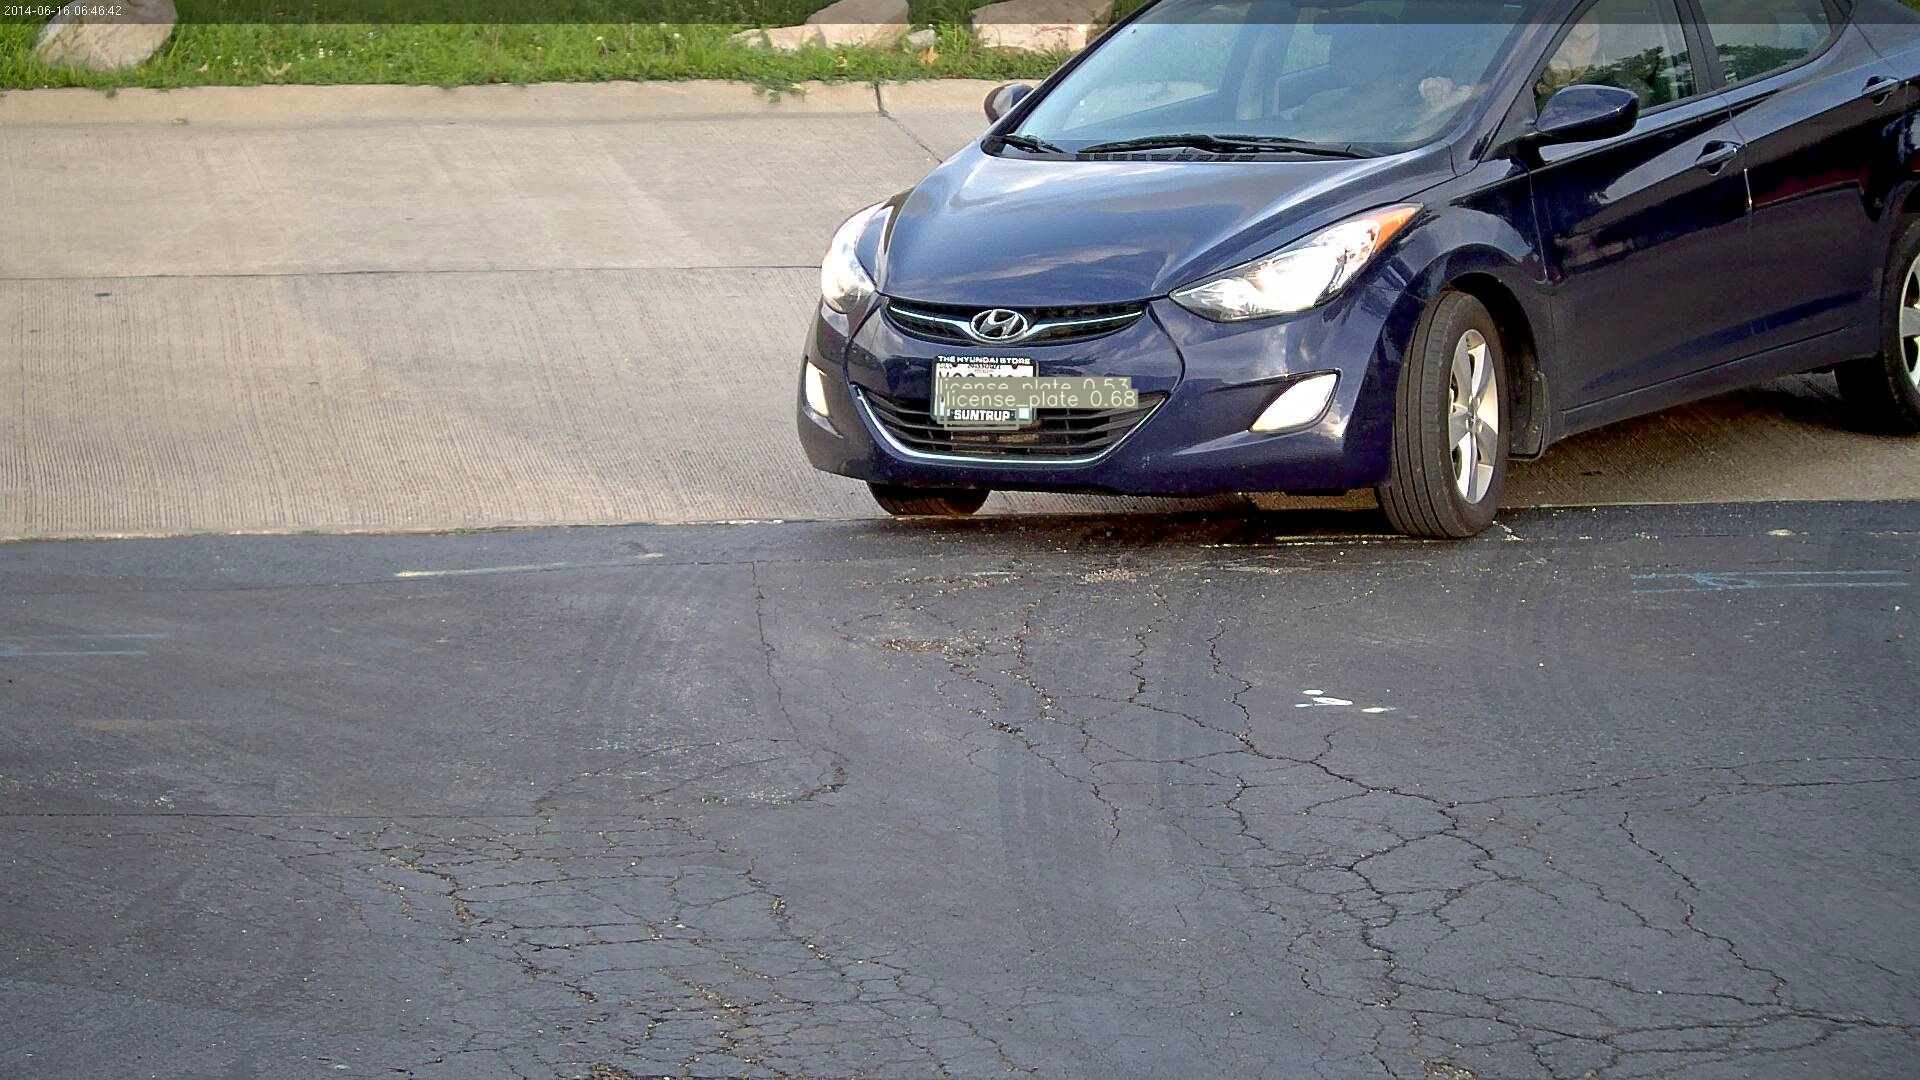

In [28]:
Image('runs/detect/exp/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

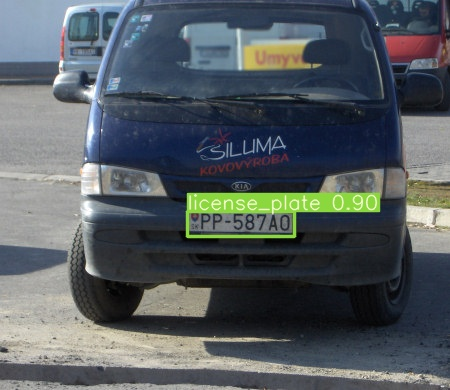

In [ ]:
Image('runs/detect/exp2/test_001.jpg')

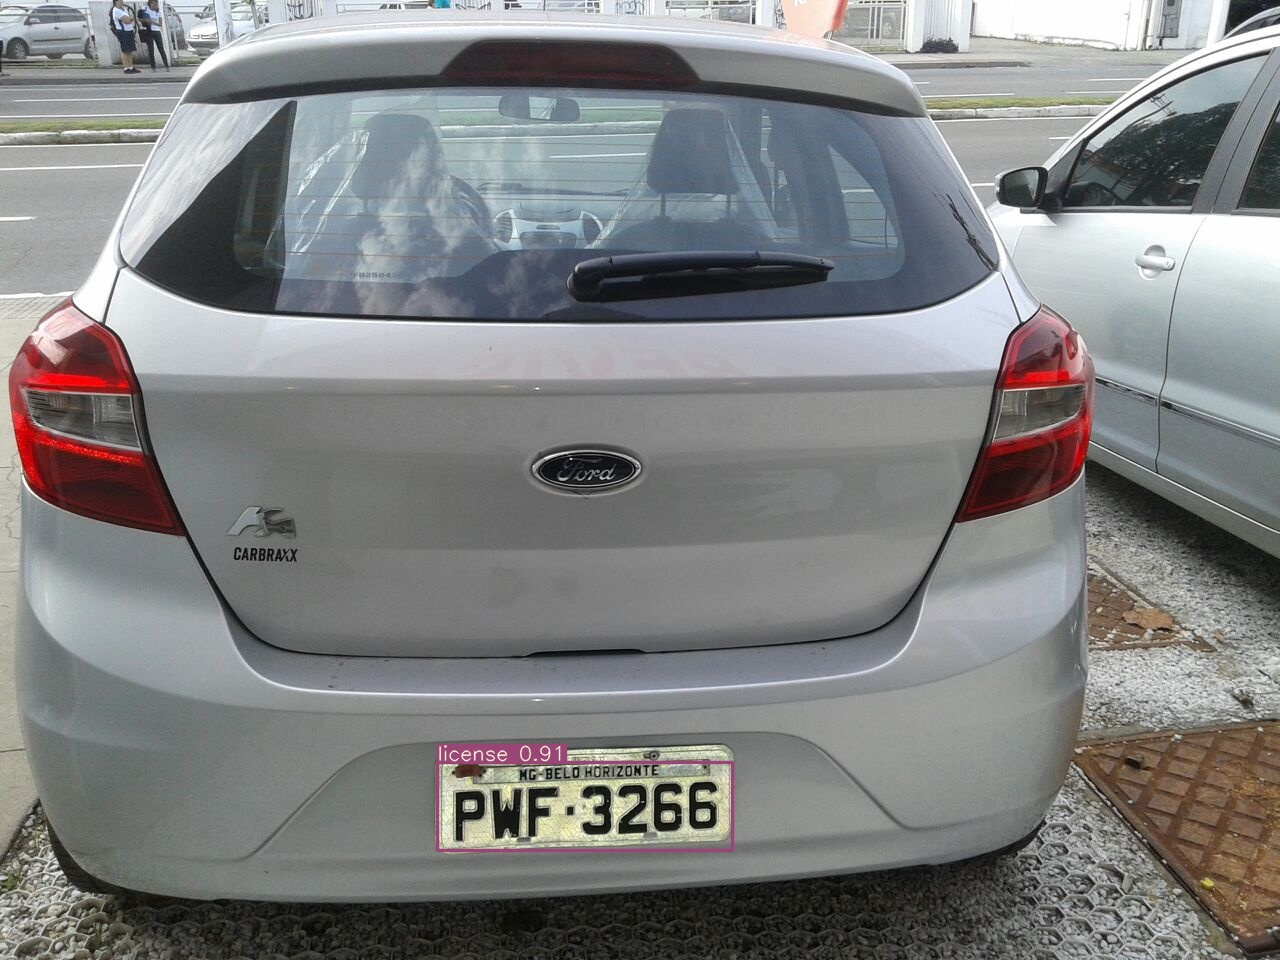

In [ ]:
Image('runs/detect/exp3/PWF3266.jpg')

## OCR 

### get detected ALPR bounding box

In [ ]:
# list saved .txt
!ls runs/detect/exp/labels

0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.txt  wts-lg-000033.txt  wts-lg-000121.txt
1e241dc8-8f18-4955-8988-03a0ab49f813.txt  wts-lg-000034.txt  wts-lg-000122.txt
21d8c31d-3deb-494b-9c63-c0223306fd82.txt  wts-lg-000035.txt  wts-lg-000123.txt
22e54a62-57a8-4a0a-88c1-4b9758f67651.txt  wts-lg-000036.txt  wts-lg-000124.txt
316b64c0-55bf-4079-a1c0-d93f461a576f.txt  wts-lg-000037.txt  wts-lg-000125.txt
33fa5185-0286-4e8f-b775-46162eba39d4.txt  wts-lg-000038.txt  wts-lg-000126.txt
37170dd1-2802-4e38-b982-c5d07c64ff67.txt  wts-lg-000039.txt  wts-lg-000127.txt
3850ba91-3c64-4c64-acba-0c46b61ec0da.txt  wts-lg-000040.txt  wts-lg-000128.txt
4be2025c-09f7-4bb0-b1bd-8e8633e6dec1.txt  wts-lg-000041.txt  wts-lg-000129.txt
5b562a61-34ad-4f00-9164-d34abb7a38e4.txt  wts-lg-000042.txt  wts-lg-000130.txt
7fbfbe28-aecb-45be-bd05-7cf26acb3c5c.txt  wts-lg-000043.txt  wts-lg-000131.txt
c9368c55-210d-456c-a5ef-c310e60039ec.txt  wts-lg-000044.txt  wts-lg-000132.txt
car11.txt				  wts-lg-000045.txt  wts-lg-000133.txt


In [ ]:
# read .txt to get x,y,w,h of ALPR
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()
         
    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        obj = [int(float(i)) for i in line.split(' ')]
        objects.append(obj)
    #print(objects)
    return objects

### OCR using PyTesseract

In [ ]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
DETECT_PATH = '/content/yolov5/runs/detect/exp/'
IMG_NAME    = 'us10'

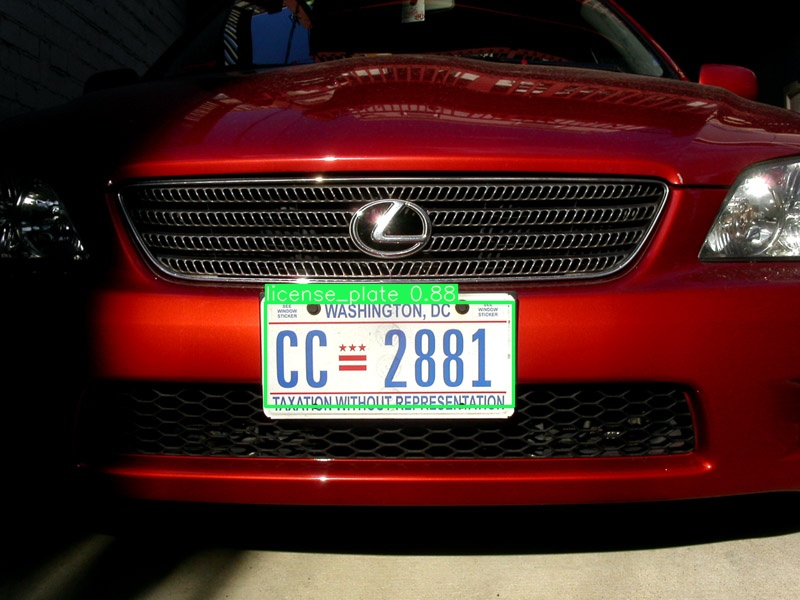

In [ ]:
Image(DETECT_PATH+IMG_NAME+'.jpg')

389 354 248 104


AttributeError: ignored

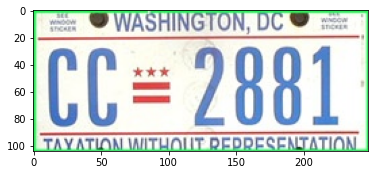

In [ ]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
img = cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')

for lic in lics:
    c, x, y, w, h = lic
    print(x,y,w,h) # center of the bounding box
    img_alpr = img[y-int(h/2):y+int(h/2),x-int(w/2):x+int(w/2)]
    plt.imshow(img_alpr)
    txt = pytesseract.image_to_string(img_alpr)
    print(txt)
    
#    img = cv2.putText(img, txt, (x-int(w/2),y-int(h/2)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)   
#cv2.imwrite('alpr_us1.jpg', img)

In [ ]:
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list